# Spotify

## Setup

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,isnan, when, count
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
import pandas as pd

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder

In [31]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [32]:
sdf = spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("./data/Spotify-2000.csv")
sdf.show()

+-----+--------------------+-----------------+--------------------+----+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Index|               Title|           Artist|           Top Genre|Year|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+-----+--------------------+-----------------+--------------------+----+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|    1|             Sunrise|      Norah Jones|     adult standards|2004|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|    2|         Black Night|      Deep Purple|          album rock|2000|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|       

In [33]:
sdf = sdf.drop("Title").drop("Year").drop("Year").drop("Index")
sdf = sdf.withColumn('Length (Duration)',col('Length (Duration)').cast(IntegerType()))

In [34]:
sdf.cache()

DataFrame[Artist: string, Top Genre: string, Beats Per Minute (BPM): int, Energy: int, Danceability: int, Loudness (dB): int, Liveness: int, Valence: int, Length (Duration): int, Acousticness: int, Speechiness: int, Popularity: int]

In [35]:
sdf.is_cached

True

In [36]:
sdf.printSchema()

root
 |-- Artist: string (nullable = true)
 |-- Top Genre: string (nullable = true)
 |-- Beats Per Minute (BPM): integer (nullable = true)
 |-- Energy: integer (nullable = true)
 |-- Danceability: integer (nullable = true)
 |-- Loudness (dB): integer (nullable = true)
 |-- Liveness: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Length (Duration): integer (nullable = true)
 |-- Acousticness: integer (nullable = true)
 |-- Speechiness: integer (nullable = true)
 |-- Popularity: integer (nullable = true)



## Data exploration

In [37]:
sdf = sdf.na.drop()

In [38]:
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

+------+---------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Artist|Top Genre|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+------+---------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|     0|        0|                     0|     0|           0|            0|       0|      0|                0|           0|          0|         0|
+------+---------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+



## Describe

In [39]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_num = sdf.select([col[0] for col in sdf.dtypes if col[1] != 'string'])
col_num.show()

feature_numeric = ['Beats Per Minute (BPM)', 'Energy', 'Danceability',  'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)', 'Acousticness', 'Speechiness', 'Popularity']

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|                   168|    69|          66|           -9|       7|     52|              341|           2|         17|        69|
|                   173|    96|          43|           -4|       3|     37|              269|           0|          4|        76|
|                   106|    82|          58|           -5|      10|     87|              2

In [40]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_cat = sdf.select([col[0] for col in sdf.dtypes if col[1] == 'string'])
col_cat.show()

+-----------------+--------------------+
|           Artist|           Top Genre|
+-----------------+--------------------+
|      Norah Jones|     adult standards|
|      Deep Purple|          album rock|
|         Gorillaz| alternative hip hop|
|     Foo Fighters|   alternative metal|
|Bruce Springsteen|        classic rock|
|     City To City|alternative pop rock|
|         Maroon 5|                 pop|
|             Muse|         modern rock|
|      The Killers|         modern rock|
|           Eminem|     detroit hip hop|
|    Elvis Presley|     adult standards|
|The White Stripes|    alternative rock|
|          De Dijk|         dutch indie|
|  Ten Years After|          album rock|
|   Arctic Monkeys|         garage rock|
|    Paul de Leeuw|       dutch cabaret|
|         Coldplay|      permanent wave|
|Alanis Morissette|    alternative rock|
|       John Miles|      classic uk pop|
|Justin Timberlake|           dance pop|
+-----------------+--------------------+
only showing top

In [41]:
feature_cat = ["Artist", "Top Genre"]
feature_cat_indexed = [col+'_indexed' for col in feature_cat]

In [42]:
labelCol = 'Popularity'

In [43]:
feature_cat_encoded = [col +'_encoded' for col in feature_cat_indexed]

## StringIndexer

In [44]:
indexer_feature = StringIndexer(inputCols=feature_cat, handleInvalid='skip', outputCols=feature_cat_indexed)
indexer_label = StringIndexer(inputCol=labelCol, handleInvalid='skip', outputCol=labelCol+'_indexed')
#sdf = indexer_feature.fit(sdf).transform(sdf)

## OneHotEncoder

In [45]:
sdf.show()

+-----------------+--------------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|           Artist|           Top Genre|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+-----------------+--------------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|      Norah Jones|     adult standards|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|      Deep Purple|          album rock|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|         Gorillaz| alternative hip hop|                   168|    69|          66|           -9|       7|     52|              341|           2|         1

In [46]:
encoders = OneHotEncoder(dropLast=False, inputCols=feature_cat_indexed, outputCols=feature_cat_encoded)  # handleInvalid='skip',  
#sdf = encoders.fit(sdf).transform(sdf)
#sdf.select(feature_cat_indexed+feature_cat_encoded).show(n=2, truncate=False, vertical=True)

## VectorAssembler

In [47]:
# Vectorizing encoded values
# assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="rawFeatures")

assembler = VectorAssembler(inputCols=feature_cat_encoded+feature_numeric, outputCol='features')

#assembler.transform(sdf).select(feature_cat+feature_numeric+feature_cat_encoded+['features']).show(n=2, truncate=False, vertical=True)

### Pipeline

In [48]:
#Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler]).fit(sdf).transform(sdf).show(n=1, truncate=False, vertical=True)

In [49]:
sdf.printSchema()

root
 |-- Artist: string (nullable = true)
 |-- Top Genre: string (nullable = true)
 |-- Beats Per Minute (BPM): integer (nullable = true)
 |-- Energy: integer (nullable = true)
 |-- Danceability: integer (nullable = true)
 |-- Loudness (dB): integer (nullable = true)
 |-- Liveness: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Length (Duration): integer (nullable = true)
 |-- Acousticness: integer (nullable = true)
 |-- Speechiness: integer (nullable = true)
 |-- Popularity: integer (nullable = true)



In [50]:
train, test = sdf.randomSplit([0.7, 0.3],seed = 11)
train.show(n=1, truncate=False, vertical=True)
test.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------
 Artist                 | 10cc       
 Top Genre              | album rock 
 Beats Per Minute (BPM) | 98         
 Energy                 | 50         
 Danceability           | 52         
 Loudness (dB)          | -11        
 Liveness               | 11         
 Valence                | 66         
 Length (Duration)      | 242        
 Acousticness           | 16         
 Speechiness            | 3          
 Popularity             | 46         
only showing top 1 row

-RECORD 0------------------------
 Artist                 | 2Pac   
 Top Genre              | g funk 
 Beats Per Minute (BPM) | 111    
 Energy                 | 66     
 Danceability           | 87     
 Loudness (dB)          | -7     
 Liveness               | 14     
 Valence                | 32     
 Length (Duration)      | 269    
 Acousticness           | 4      
 Speechiness            | 8      
 Popularity             | 72     
only showing top 1 row



In [51]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='Popularity_indexed', featuresCol='features')

train, test = sdf.randomSplit([0.7, 0.3], seed = 11)

train.cache()
test.cache()
train.show()

model = Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler] + [lr]).fit(train)
pred_lr = model.transform(test)
pred_lr.select('prediction', 'Popularity_indexed', 'features').show()
pred_lr.show(n=1, vertical=True, truncate=False)

+-------------------+-----------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|             Artist|        Top Genre|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+-------------------+-----------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|               10cc|       album rock|                    98|    50|          52|          -11|      11|     66|              242|          16|          3|        46|
|               10cc|       album rock|                   105|    38|          84|          -13|      20|     89|              268|          54|          6|        67|
|               10cc|       album rock|                   134|    52|          40|          -16|      28|     16|              367|          69|          6|    

## Scatter plot

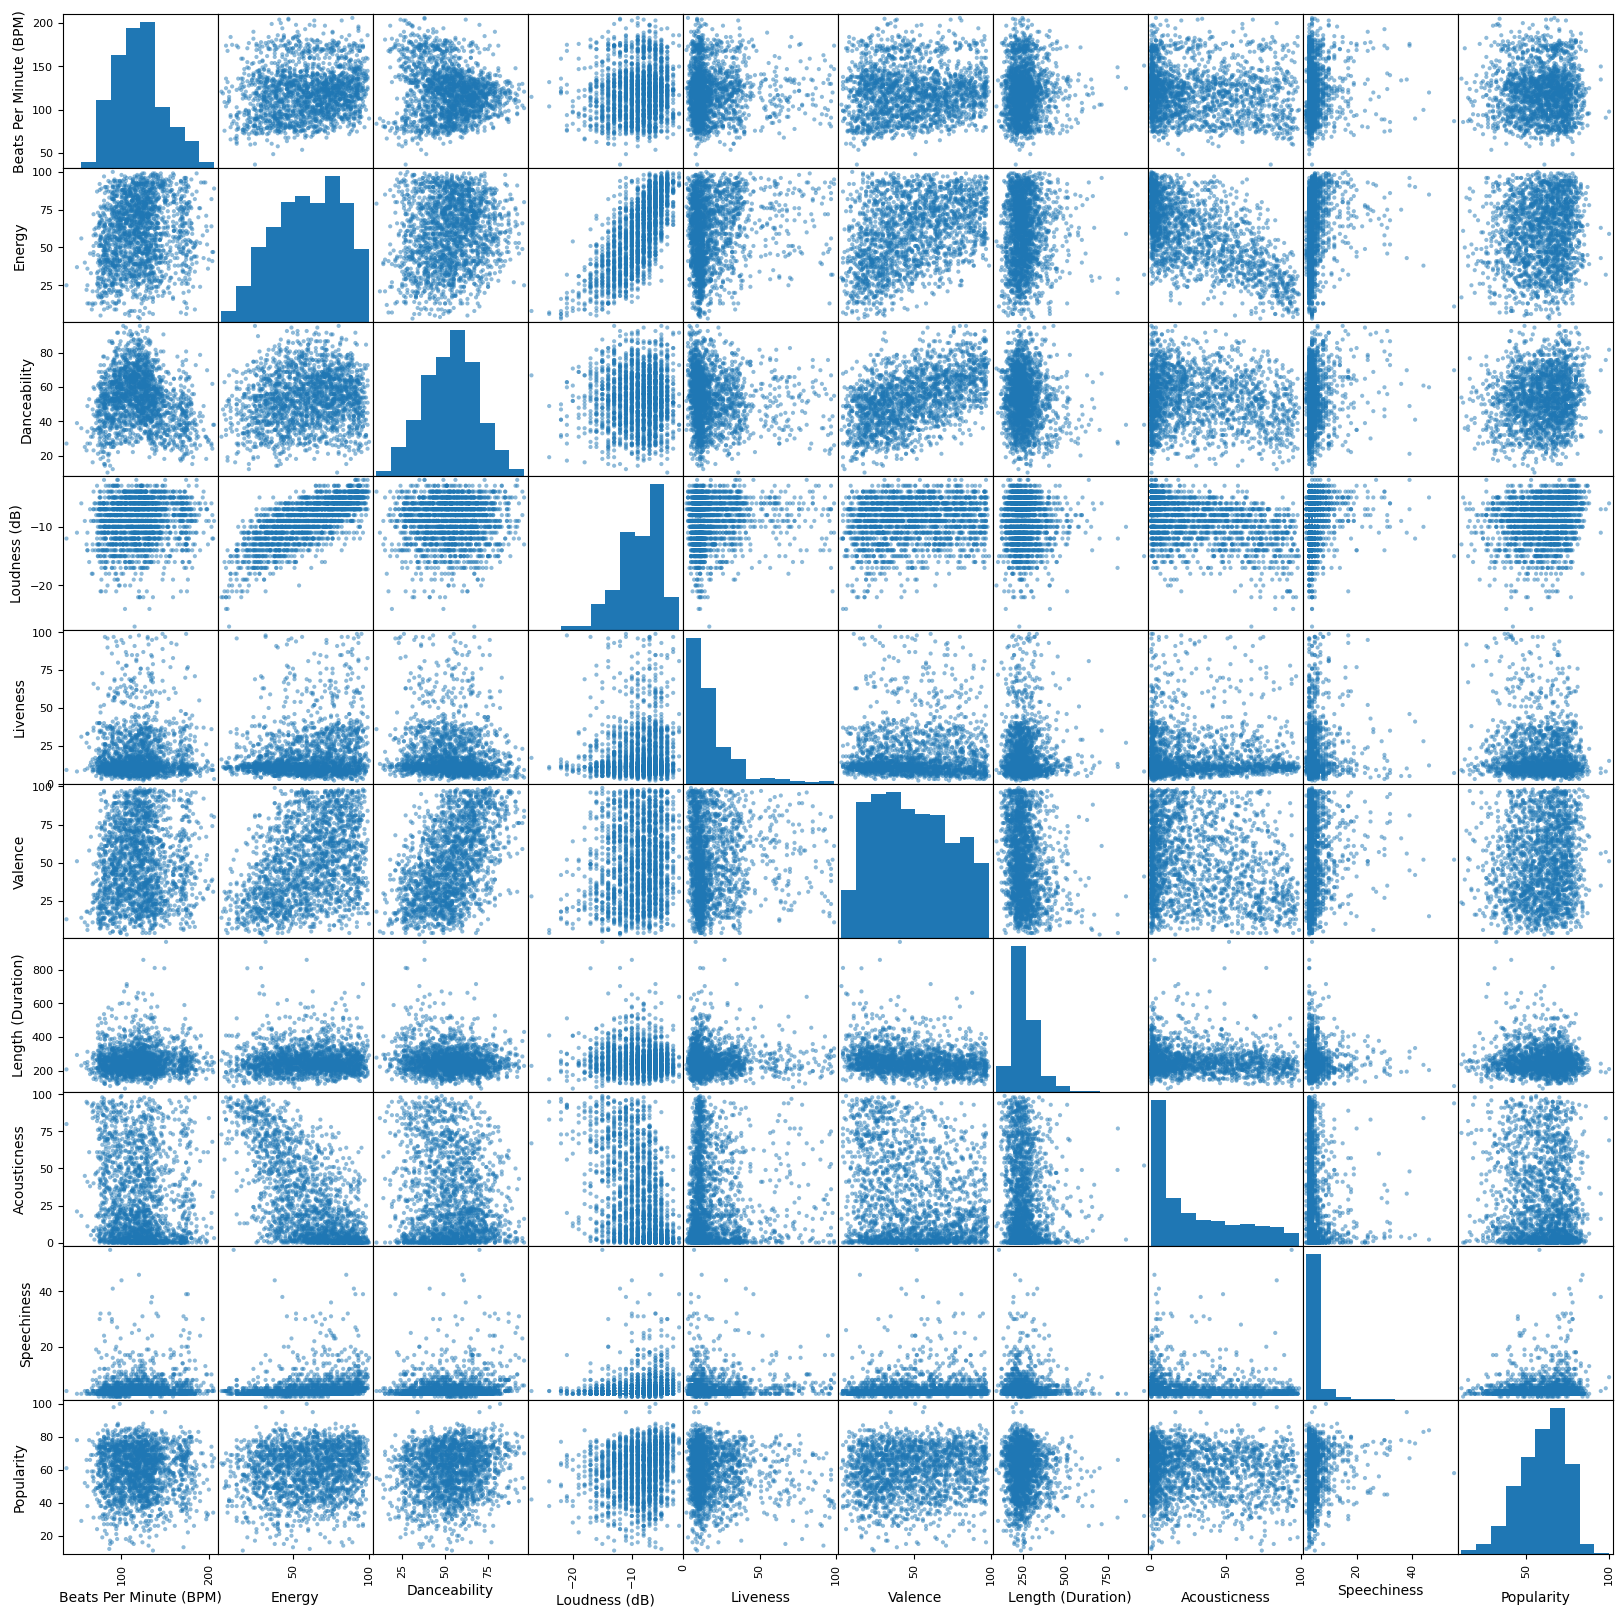

In [52]:
from pandas.plotting import scatter_matrix

pandasSdf = sdf.toPandas()
scatterMatrix = scatter_matrix(pandasSdf,figsize=(20,20))

# Notre target est la colonne "Popularity"
# Nous avons choisi de l'utiliser en temps qu'axe Y pour étudier l'impact des autres colonnes sur la "Popularity"
